In [2]:
import numpy as np
import seaborn as sns
import scipy.io
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

STEP 1: Load and Visualize Data


In [3]:
# Load the .mat file
data = scipy.io.loadmat('S1_E1_A1.mat')

# Display the keys in the file
print(data.keys())


dict_keys(['__header__', '__version__', '__globals__', 'subject', 'exercise', 'emg', 'acc', 'gyro', 'mag', 'glove', 'stimulus', 'repetition', 'restimulus', 'rerepetition'])


In [4]:
print(data['glove'].shape)  # Check the shape of the data
print(data['glove'])        # Optionally, print the data or a subset


(2292526, 18)
[[ 46.5872    -14.4243555  22.320053  ...  41.629326    2.8205853
    5.1383142]
 [ 46.5872    -14.4243555  22.320053  ...  41.629326    2.8205853
    5.1383142]
 [ 46.5872    -14.4243555  22.320053  ...  41.629326    2.8205853
    5.1383142]
 ...
 [ 50.314175  -25.619379   24.861235  ...  62.55128     8.919148
    3.5572944]
 [ 50.314175  -25.619379   24.861235  ...  62.55128     8.919148
    3.5572944]
 [ 50.314175  -25.619379   24.861235  ...  62.55128     8.919148
    3.5572944]]


/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


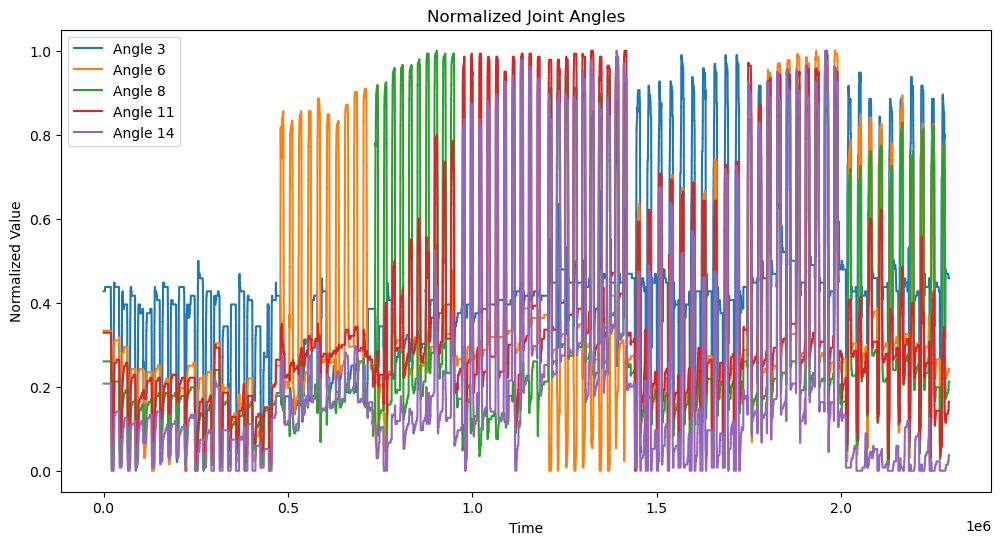

In [5]:
# Select angles 3, 6, 8, 11, 14 (indices 2, 5, 7, 10, 13 in 0-based indexing)
selected_angles = data['glove'][:, [2, 5, 7, 10, 13]]

# Normalize each angle (Min-Max scaling)
normalized_angles = (selected_angles - np.min(selected_angles, axis=0)) / (np.max(selected_angles, axis=0) - np.min(selected_angles, axis=0))

# Visualize the normalized joint angles
plt.figure(figsize=(12, 6))
for i, angle in enumerate(['Angle 3', 'Angle 6', 'Angle 8', 'Angle 11', 'Angle 14']):
    plt.plot(normalized_angles[:, i], label=angle)
plt.title('Normalized Joint Angles')
plt.xlabel('Time')
plt.ylabel('Normalized Value')
plt.legend()
plt.show()


In [6]:
# Define split percentages
train_split = int(0.7 * len(normalized_angles))
val_split = int(0.85 * len(normalized_angles))

# Split into training, validation, and test sets
x_train = normalized_angles[:train_split]
x_val = normalized_angles[train_split:val_split]
x_test = normalized_angles[val_split:]

# Print shapes of the splits
print(f'Training set shape: {x_train.shape}')
print(f'Validation set shape: {x_val.shape}')
print(f'Testing set shape: {x_test.shape}')


Training set shape: (1604768, 5)
Validation set shape: (343879, 5)
Testing set shape: (343879, 5)


STEP 2: Sliding Windows

In [7]:
def sliding_window(data, window_size, step_size):
    windows = []
    for start in range(0, len(data) - window_size + 1, step_size):
        windows.append(data[start:start + window_size])
    return np.array(windows)

# Parameters
window_size = 50  # 50 samples per window
step_size = 10    # Step of 10 samples

# Apply sliding window
train_windows = sliding_window(x_train, window_size, step_size)
val_windows = sliding_window(x_val, window_size, step_size)
test_windows = sliding_window(x_test, window_size, step_size)

print(f'Training windows shape: {train_windows.shape}')


Training windows shape: (160472, 50, 5)


STEP 3:

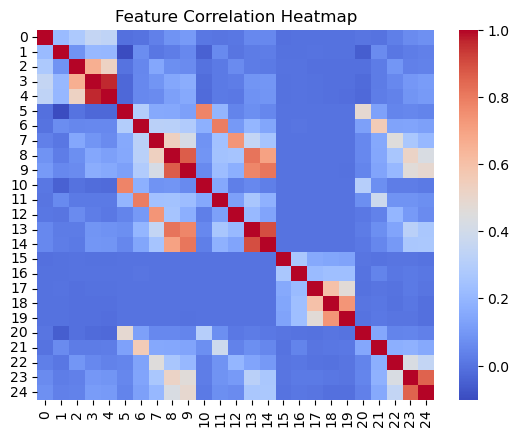

In [8]:
def extract_features(windows):
    features = []
    for window in windows:
        mean = np.mean(window, axis=0)
        std_dev = np.std(window, axis=0)
        variance = np.var(window, axis=0)
        skewness = np.mean((window - mean)**3, axis=0) / (std_dev**3 + 1e-8)
        kurtosis = np.mean((window - mean)**4, axis=0) / (std_dev**4 + 1e-8)
        features.append(np.concatenate([mean, std_dev, variance, skewness, kurtosis]))
    return np.array(features)

# Extract features for each set
train_features = extract_features(train_windows)
val_features = extract_features(val_windows)
test_features = extract_features(test_windows)

# Correlation heatmap
sns.heatmap(np.corrcoef(train_features, rowvar=False), annot=False, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()


STEP 4: 

Training MSE for Angle 3: 5.792854992534811e-06
Validation MSE for Angle 3: 3.0344131389477978e-05
Testing MSE for Angle 3: 3.105467740247749e-05
Training MSE for Angle 6: 6.473293735754335e-06
Validation MSE for Angle 6: 0.0006152929551053495
Testing MSE for Angle 6: 0.0002546731412802473
Training MSE for Angle 8: 8.71418041631842e-06
Validation MSE for Angle 8: 2.629257514200807e-05
Testing MSE for Angle 8: 2.4961250198599845e-05
Training MSE for Angle 11: 1.0402571478151767e-05
Validation MSE for Angle 11: 2.665363133215001e-05
Testing MSE for Angle 11: 1.3392318192825087e-05
Training MSE for Angle 14: 1.1533944943530603e-05
Validation MSE for Angle 14: 4.1083646017009635e-05
Testing MSE for Angle 14: 1.0968321001894173e-05


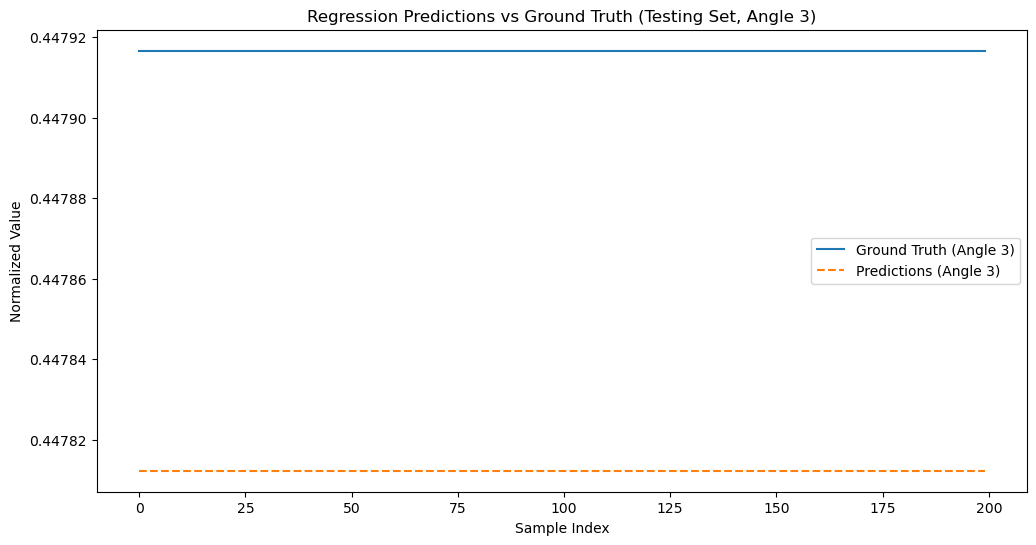

In [11]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# Train the regression model using MultiOutputRegressor
model = MultiOutputRegressor(GradientBoostingRegressor())
model.fit(train_features, train_targets)

# Predictions
train_preds = model.predict(train_features)
val_preds = model.predict(val_features)
test_preds = model.predict(test_features)

# Evaluate the performance for each joint angle
train_mse = mean_squared_error(train_targets, train_preds, multioutput='raw_values')
val_mse = mean_squared_error(val_targets, val_preds, multioutput='raw_values')
test_mse = mean_squared_error(test_targets, test_preds, multioutput='raw_values')

# Print MSE for each joint angle
for i, angle in enumerate(['Angle 3', 'Angle 6', 'Angle 8', 'Angle 11', 'Angle 14']):
    print(f"Training MSE for {angle}: {train_mse[i]}")
    print(f"Validation MSE for {angle}: {val_mse[i]}")
    print(f"Testing MSE for {angle}: {test_mse[i]}")

# Visualize predictions vs ground truth for one joint angle (e.g., Angle 3)
plt.figure(figsize=(12, 6))
plt.plot(test_targets[:200, 0], label='Ground Truth (Angle 3)')  # Ground truth for Angle 3
plt.plot(test_preds[:200, 0], label='Predictions (Angle 3)', linestyle='--')
plt.title('Regression Predictions vs Ground Truth (Testing Set, Angle 3)')
plt.xlabel('Sample Index')
plt.ylabel('Normalized Value')
plt.legend()
plt.show()


Debbug

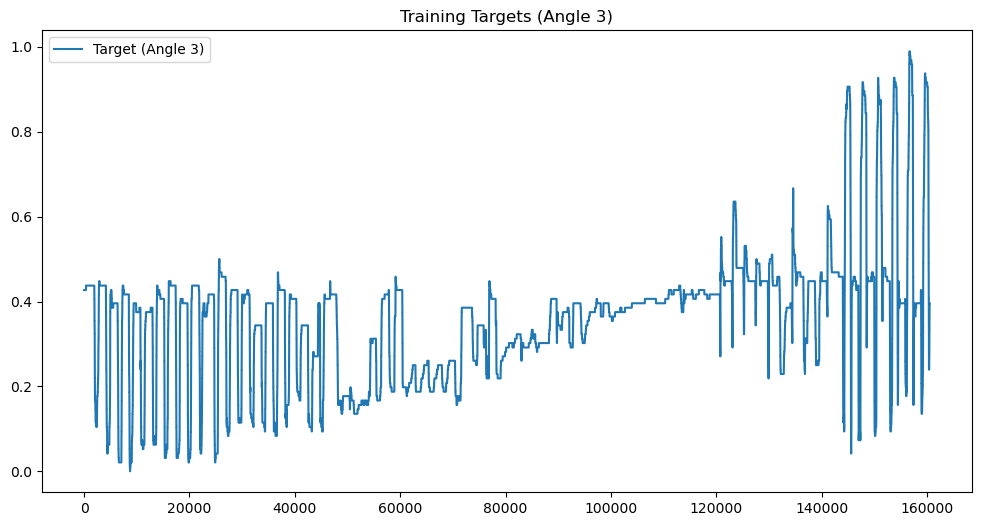

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(train_targets[:, 0], label='Target (Angle 3)')
plt.title('Training Targets (Angle 3)')
plt.legend()
plt.show()

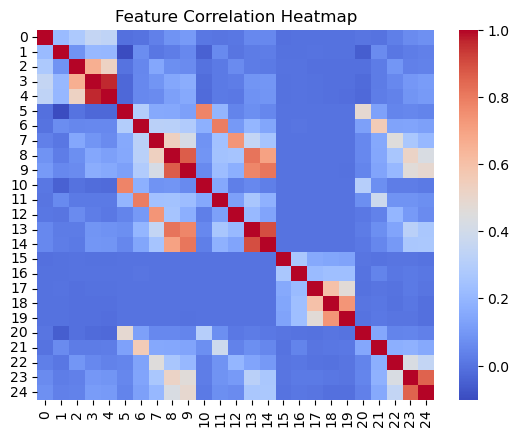

In [14]:
import seaborn as sns

correlation_matrix = np.corrcoef(train_features, rowvar=False)
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()


In [15]:
def root_mean_square(window):
    return np.sqrt(np.mean(window**2, axis=0))

rms_features = np.array([root_mean_square(w) for w in train_windows])


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'estimator__n_estimators': [50, 100, 200],
    'estimator__learning_rate': [0.01, 0.1, 0.2],
    'estimator__max_depth': [3, 5, 7]
}

grid_search = GridSearchCV(MultiOutputRegressor(GradientBoostingRegressor()), param_grid, cv=3)
grid_search.fit(train_features, train_targets)
print("Best Parameters:", grid_search.best_params_)
